In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data/0.csv
data/.DS_Store
data/1.csv
data/3.csv
data/2.csv


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df0 = pd.read_csv("data/0.csv", header=None)
print("Class 0 Shape", df0.shape)
df1 = pd.read_csv("data/1.csv", header=None)
print("Class 1 Shape", df1.shape)
df2 = pd.read_csv("data/2.csv", header=None)
print("Class 2 Shape", df2.shape)
df3 = pd.read_csv("data/3.csv", header=None)
print("Class 3 Shape", df3.shape)


df = pd.concat([df0,df1,df2,df3])
data = df.values

sc = MinMaxScaler(feature_range = (0, 1))

Class 0 Shape (2910, 65)
Class 1 Shape (2903, 65)
Class 2 Shape (2943, 65)
Class 3 Shape (2922, 65)


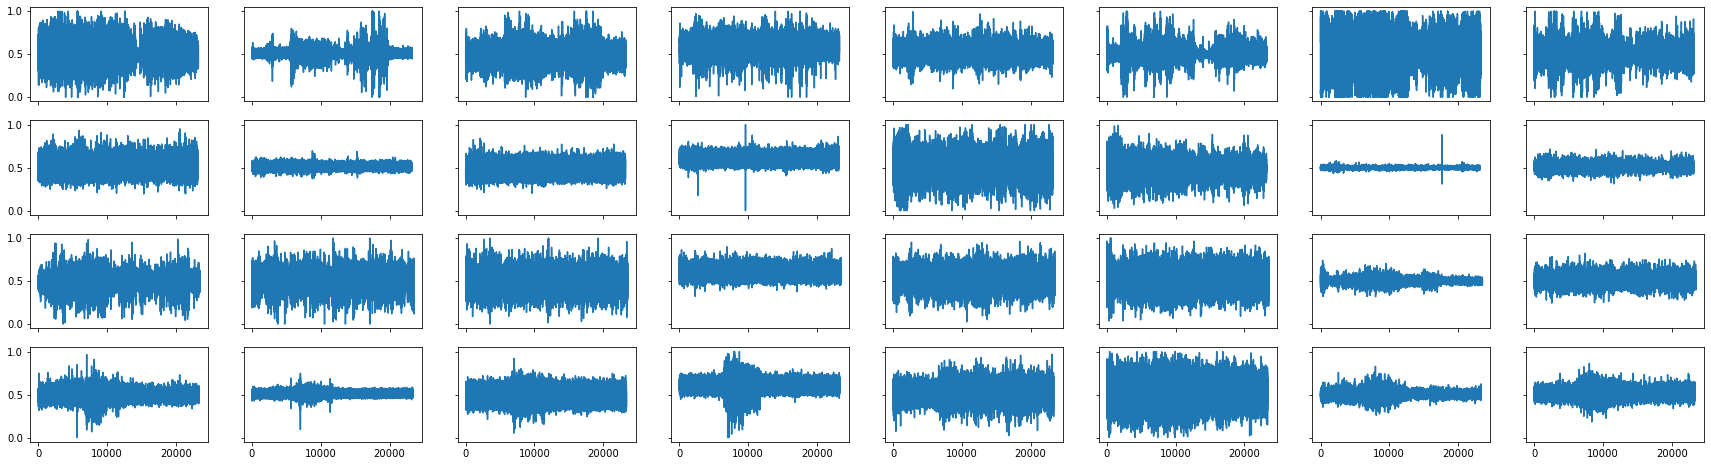

In [4]:
def plot_data(data):
    
    X0, X1, X2, X3=[],[],[],[]
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    
    for i in range(data.shape[0]):
        tmp = data[i,:-1].reshape((8,8))
        for j in range(8):
            
            if data[i,-1] == 0:
                X0.append(tmp[j,:])
            
            elif data[i,-1] == 1:
                X1.append(tmp[j,:])
            
            elif data[i,-1] == 2:
                X2.append(tmp[j,:])

            elif data[i,-1] == 3:
                X3.append(tmp[j,:])
    
    X0, X1, X2, X3 = np.array(X0), np.array(X1), np.array(X2), np.array(X3)    
        
    fig, axes = plt.subplots(4,8, figsize=(30, 8), sharex=True, sharey=True)
    for i in range(8):
        axes[0][i].plot(X0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(X1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(X2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(X3[:,i], label='Raw Ch '+str(i))
        
plot_data(data)

In [17]:
class ClickNet(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_sequence, n_layers, n_classes):
        super(ClickNet, self).__init__()
        
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes
        
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        
        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=128)
        self.dropout_1 = nn.Dropout(p=0.2)
        
        self.linear_2 = nn.Linear(in_features=128, out_features=n_classes)        
        
    
    def forward(self, x):
        
        self.hidden = (
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device),
            torch.zeros(self.n_layers, x.shape[0], self.n_hidden).to(device)
        )
    
        out, (hs, cs) = self.lstm(x.view(len(x), self.n_sequence, -1),self.hidden)
        out = out[:,-1,:]
        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)
        
        return out
    

    
def train_model(model, train_dataloader, n_epochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    
    for epoch in range(n_epochs):

        for i, (X_train, y_train) in enumerate(train_dataloader):
            
            y_hat = model(X_train)
            
            loss = loss_fn(y_hat.float(), y_train)

            if i == 0 and (epoch+1)%10==0:
                print(f'Epoch {epoch+1} train loss: {loss.item()}')

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        
    return model

In [18]:
def one_hot(a):
    a=a.astype(int)
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

def prepare_data(data):
    data[:,:-1] = sc.fit_transform(data[:,:-1])
    np.random.shuffle(data)
    X, y = data[:,:-1], data[:,-1]
    X = X.reshape(-1,8,8)
#     y=one_hot(y)
    
    X_train = torch.from_numpy(X[:7700])
    y_train = torch.from_numpy(y[:7700])
    X_test = torch.from_numpy(X[7700:])
    y_test = torch.from_numpy(y[7700:])
    
    return X_train.float().to(device), y_train.long().to(device), X_test.float().to(device), y_test.long().to(device)



def prepare_data_2():
    rock_dataset = pd.read_csv("/kaggle/input/emg-4/0.csv", header=None) # class = 0
    scissors_dataset = pd.read_csv("/kaggle/input/emg-4/1.csv", header=None) # class = 1
    paper_dataset = pd.read_csv("/kaggle/input/emg-4/2.csv", header=None) # class = 2
    ok_dataset = pd.read_csv("/kaggle/input/emg-4/3.csv", header=None) # class = 3

    frames = [rock_dataset, scissors_dataset, paper_dataset, ok_dataset]
    dataset = pd.concat(frames)

    dataset_train = dataset.iloc[np.random.permutation(len(dataset))]
    dataset_train.reset_index(drop=True)

    X_train = []
    y_train = []

    for i in range(0, dataset_train.shape[0]):
        row = np.array(dataset_train.iloc[i:1+i, 0:64].values)
        X_train.append(np.reshape(row, (64, 1)))
        y_train.append(np.array(dataset_train.iloc[i:1+i, -1:])[0][0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # Reshape to one flatten vector
    X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], 1)
    X_train = sc.fit_transform(X_train)

    # Reshape again after normalization to (-1, 8, 8)
    X_train = X_train.reshape((-1, 8, 8))

    # Convert to one hot
    y_train = np.eye(np.max(y_train) + 1)[y_train]


    # Splitting Train/Test
    X_test = torch.from_numpy(X_train[7700:])
    y_test = torch.from_numpy(y_train[7700:])
    
    X_train = torch.from_numpy(X_train[0:7700])
    y_train = torch.from_numpy(y_train[0:7700])
    
    return X_train.float().to(device), y_train.float().to(device), X_test.float().to(device), y_test.float().to(device)

In [15]:
class EmgDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
    
n_features=8
n_sequence=8
n_hidden=64
n_layers=1
n_classes=4

n_epochs = 500
n_batch_size = 256

model = ClickNet(n_features, n_hidden, n_sequence, n_layers, n_classes).to(device)
X_train, y_train, X_test, y_test = prepare_data(data)
# X_train, y_train, X_test, y_test = prepare_data_2()


print("Train Data Shape ",X_train.shape, y_train.shape)
print("Test Data Shape ",X_test.shape, y_test.shape)

train_dataset = EmgDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset, batch_size=n_batch_size, shuffle=True)
model = train_model(model, train_dataloader, n_epochs = n_epochs)

Train Data Shape  torch.Size([7700, 8, 8]) torch.Size([7700])
Test Data Shape  torch.Size([3978, 8, 8]) torch.Size([3978])
Epoch 10 train loss: 1.3812141418457031
Epoch 20 train loss: 1.04812490940094
Epoch 30 train loss: 0.7866935133934021
Epoch 40 train loss: 0.7467294335365295
Epoch 50 train loss: 0.7261350154876709
Epoch 60 train loss: 0.6873015761375427
Epoch 70 train loss: 0.48990678787231445
Epoch 80 train loss: 0.388362318277359
Epoch 90 train loss: 0.20974330604076385
Epoch 100 train loss: 0.1879279762506485
Epoch 110 train loss: 0.289960652589798
Epoch 120 train loss: 0.12462598085403442
Epoch 130 train loss: 0.2813742458820343
Epoch 140 train loss: 0.12741300463676453
Epoch 150 train loss: 0.13716407120227814
Epoch 160 train loss: 0.14198334515094757
Epoch 170 train loss: 0.09717170894145966
Epoch 180 train loss: 0.07876493036746979
Epoch 190 train loss: 0.08071840554475784
Epoch 200 train loss: 0.04761862754821777
Epoch 210 train loss: 0.024159979075193405
Epoch 220 train l

In [16]:
def evaluateModel(prediction, y):
    prediction = torch.argmax(prediction, dim=1)
#     y = torch.argmax(y, dim=1)
    good = 0
    for i in range(len(y)):
        if (prediction[i] == y[i]):
            good = good +1
    return (good/len(y)) * 100.0


with torch.no_grad():
    y_hat_train = model(X_train)
    print("Train Accuracy ", evaluateModel(y_hat_train, y_train))
    
    y_hat_test = model(X_test)
    print("Test Accuracy ", evaluateModel(y_hat_test, y_test))

Train Accuracy  98.48051948051948
Test Accuracy  92.96128707893413
